## Test set evaluation - model 220221

In [1]:
import os
import csv
import numpy as np

from sklearn import metrics
from sklearn.metrics import roc_auc_score

from matplotlib import pylab as plt
import pandas as pd
from collections import Counter


In [2]:
def se_sp(ref, obs):
    tp = np.sum((ref == 1) & (obs == 1))
    tn = np.sum((ref == 0) & (obs == 0))
    fp = np.sum((ref == 0) & (obs == 1))
    fn = np.sum((ref == 1) & (obs == 0))

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity, tp, tn, fp, fn

## Load graders scores

In [3]:
import pickle

try:
    with open('all_gradings_base.pickle', 'rb') as f:
        all_gradings = pickle.load(f)
except:
    grader_folder = '/media/QNAP/People/BartLiefers/ROP/Independent Test/'

    #Himanshu Patel - Consultant
    #Anne-Marie Hinds - Consultant
    #Rob Henderson - Consultant
    #Meena Arun - Fellow
    #Janette Ravello - Nurse specialist

    all_gradings = {}
    for grader in 'HP', 'AMH', 'MA', 'RH':
        for grading in 'Normal', 'Plus', 'Pre-Plus':
            folder = '/media/QNAP/People/BartLiefers/ROP/Independent Test/{}/{}'.format(grader, grading)
            if grader == 'RH':
                folder = '/media/QNAP/People/BartLiefers/ROP/Independent Test/{}/ROP AI project/{}'.format(grader, grading)
            for filename in os.listdir(folder):
                if not filename.endswith('.png'):
                     continue
                all_gradings[grader, filename] = grading.lower()

    df = pd.read_excel('/media/QNAP/People/BartLiefers/ROP/Independent Test/JR/Copy of Ravelo_ROP.xlsx', engine='openpyxl')
    for i, row in df.iterrows():
        all_gradings['JR', row.File] = row.Diagnosis.lower()

    with open('all_gradings_base.pickle', 'wb') as f:
        pickle.dump(all_gradings, f)
    
len(all_gradings)

1000

In [4]:
# these are the files graded by all
test_filenames = list(set(filename for grader, filename in all_gradings))
len(test_filenames)

200

## Other graders plus reference 

In [5]:
with open('../src/data/new_data_split.csv', 'r') as f:
    reader = csv.reader(f)
    grading_header = next(reader)
    grading_data = list(reader)
    
for row in grading_data:
    for grader, grading in zip(grading_header[2:], row[2:]):
        filename = row[0]
        if filename in test_filenames:
            all_gradings[grader, filename] = grading

In [6]:
len(all_gradings)

2200

In [7]:
# export
with open('all_gradings_test_set.csv', 'w') as f:
    csv.writer(f).writerows([(*k, v) for k, v in all_gradings.items()])

In [8]:
all_graders = 'HP', 'AMH', 'RH', 'MA', 'JR', 'GA', 'CH', 'JT', 'CK', 'SB'
class_names = 'normal', 'pre-plus', 'plus'

In [9]:
graders_full_set = {
    g for g in all_graders 
    if all(all_gradings[g, f] in class_names for f in test_filenames)
}

In [10]:
graders_full_set

{'AMH', 'CH', 'CK', 'GA', 'HP', 'JR', 'JT', 'MA', 'RH', 'SB'}

In [11]:
all_graders

('HP', 'AMH', 'RH', 'MA', 'JR', 'GA', 'CH', 'JT', 'CK', 'SB')

## Majority

In [12]:
for fn in test_filenames:
    counts = Counter([all_gradings[grader, fn] for grader in all_graders])
    majority, _ = counts.most_common(1)[0]
    all_gradings['majority', fn] = majority

## Load model output

In [13]:
with open('model220221_classification_all_files.csv', 'r') as f:
    reader = csv.reader(f)
    model_header = next(reader)
    model_data = list(reader)

model_gradings = {}    
for file, model, normal, pre_plus, plus in model_data:
    model_gradings[file, int(model), 'normal'] = float(normal)
    model_gradings[file, int(model), 'pre-plus'] = float(pre_plus)
    model_gradings[file, int(model), 'plus'] = float(plus)
    

## Add ensemble

In [14]:
for file in test_filenames:
    
    gradings_all_models = np.array([[
        model_gradings[file, fold, class_name] for class_name in class_names]
        for fold in range(5)])
    avg_scores = gradings_all_models.mean(axis=0)
    all_gradings['ensemble', file] = class_names[np.argmax(avg_scores)]
    
    for class_name, score in zip(class_names, avg_scores):
        model_gradings[file, class_name] = score
    

In [15]:
def print_confusion(reference, observer):
    print('{:>40s}'.format(observer))
    print('{:>18s} {:>8s} {:>8s} {:>8s}'.format('', *class_names))
    for x_class_name in class_names:
        if x_class_name == 'pre-plus':
            print('{:>18s}'.format(reference + '  ' + x_class_name), end=' ')
        else:
            print('{:>18s}'.format(x_class_name), end=' ')
            
        ref = np.array([all_gradings[reference, file] == x_class_name for file in test_filenames])
        for y_class_name in class_names:
            obs = np.array([all_gradings[observer, file] == y_class_name for file in test_filenames])
            print('{:8d}'.format(np.count_nonzero(ref & obs)), end=' ')
        print()
        
    print()
    print('referability (normal vs plus/pre-plus)')
    r = np.array([all_gradings[reference, file] != 'normal' for file in test_filenames])
    o = np.array([all_gradings[observer, file] != 'normal' for file in test_filenames])
    sensitivity, specificity, tp, tn, fp, fn = se_sp(r, o)
    print('sensitivity: {:.3f}'.format(sensitivity))
    print('specificity: {:.3f}'.format(specificity))

In [16]:
from itertools import combinations
for ref, obs in combinations(all_graders, 2):
    print_confusion(ref, obs)

                                     AMH
                     normal pre-plus     plus
            normal      108        7        1 
      HP  pre-plus        4       40        2 
              plus        0       15       23 

referability (normal vs plus/pre-plus)
sensitivity: 0.952
specificity: 0.931
                                      RH
                     normal pre-plus     plus
            normal       99       16        1 
      HP  pre-plus        0       27       19 
              plus        0        0       38 

referability (normal vs plus/pre-plus)
sensitivity: 1.000
specificity: 0.853
                                      MA
                     normal pre-plus     plus
            normal      107        9        0 
      HP  pre-plus        4       37        5 
              plus        0       11       27 

referability (normal vs plus/pre-plus)
sensitivity: 0.952
specificity: 0.922
                                      JR
                     normal pre-plus     

## Observer scores

In [17]:
def get_se_sp(reference, observer, filenames):
    
    # normal -> 0, plus/pre-plus -> 1
    ref = np.array([int(all_gradings[reference, fn] != 'normal') for fn in filenames])
    obs = np.array([int(all_gradings[observer, fn] != 'normal') for fn in filenames])
   
    return se_sp(ref, obs) 

from IPython.display import Markdown
def display_table(reference):
    display(Markdown('## Reference {}'.format(reference)))
    table = '| {:15s} | {:>8s} | {:>8s} | {:>4s} | {:>4s} | {:>4s} | {:>4s} | {:>4s} | \n'.format('observer', 'SE', 'SP', 'TP', 'TN', 'FP', 'FN', 'N')
    table += ' --- '.join((['|']*9))
    table += '\n'
    
    for observer in all_graders + ('majority', 'ensemble'):
        if observer == reference:
             continue
        sensitivity, specificity, tp, tn, fp, fn = get_se_sp(reference, observer, test_filenames)
        table += '| {:15s} | {:>8.3f} | {:>8.3f} | {:>4d} | {:>4d} | {:>4d} | {:>4d} | {:>4d} |\n'.format(observer, sensitivity, specificity, tp, tn, fp, fn, sum([tp, tn, fp, fn]))
    display(Markdown(table))
    return table

In [18]:
# compare other graders to HP
for grader in all_graders:
    display_table(grader)

## Reference HP

| observer        |       SE |       SP |   TP |   TN |   FP |   FN |    N | 
| --- | --- | --- | --- | --- | --- | --- | --- |
| AMH             |    0.952 |    0.931 |   80 |  108 |    8 |    4 |  200 |
| RH              |    1.000 |    0.853 |   84 |   99 |   17 |    0 |  200 |
| MA              |    0.952 |    0.922 |   80 |  107 |    9 |    4 |  200 |
| JR              |    0.905 |    0.922 |   76 |  107 |    9 |    8 |  200 |
| GA              |    0.917 |    0.931 |   77 |  108 |    8 |    7 |  200 |
| CH              |    0.821 |    0.966 |   69 |  112 |    4 |   15 |  200 |
| JT              |    0.940 |    0.940 |   79 |  109 |    7 |    5 |  200 |
| CK              |    0.988 |    0.716 |   83 |   83 |   33 |    1 |  200 |
| SB              |    0.869 |    0.888 |   73 |  103 |   13 |   11 |  200 |
| majority        |    0.976 |    0.948 |   82 |  110 |    6 |    2 |  200 |
| ensemble        |    0.940 |    0.905 |   79 |  105 |   11 |    5 |  200 |


## Reference AMH

| observer        |       SE |       SP |   TP |   TN |   FP |   FN |    N | 
| --- | --- | --- | --- | --- | --- | --- | --- |
| HP              |    0.909 |    0.964 |   80 |  108 |    4 |    8 |  200 |
| RH              |    0.977 |    0.866 |   86 |   97 |   15 |    2 |  200 |
| MA              |    1.000 |    0.991 |   88 |  111 |    1 |    0 |  200 |
| JR              |    0.875 |    0.929 |   77 |  104 |    8 |   11 |  200 |
| GA              |    0.932 |    0.973 |   82 |  109 |    3 |    6 |  200 |
| CH              |    0.807 |    0.982 |   71 |  110 |    2 |   17 |  200 |
| JT              |    0.932 |    0.964 |   82 |  108 |    4 |    6 |  200 |
| CK              |    1.000 |    0.750 |   88 |   84 |   28 |    0 |  200 |
| SB              |    0.841 |    0.893 |   74 |  100 |   12 |   14 |  200 |
| majority        |    0.977 |    0.982 |   86 |  110 |    2 |    2 |  200 |
| ensemble        |    0.955 |    0.946 |   84 |  106 |    6 |    4 |  200 |


## Reference RH

| observer        |       SE |       SP |   TP |   TN |   FP |   FN |    N | 
| --- | --- | --- | --- | --- | --- | --- | --- |
| HP              |    0.832 |    1.000 |   84 |   99 |    0 |   17 |  200 |
| AMH             |    0.851 |    0.980 |   86 |   97 |    2 |   15 |  200 |
| MA              |    0.861 |    0.980 |   87 |   97 |    2 |   14 |  200 |
| JR              |    0.812 |    0.970 |   82 |   96 |    3 |   19 |  200 |
| GA              |    0.812 |    0.970 |   82 |   96 |    3 |   19 |  200 |
| CH              |    0.703 |    0.980 |   71 |   97 |    2 |   30 |  200 |
| JT              |    0.832 |    0.980 |   84 |   97 |    2 |   17 |  200 |
| CK              |    0.960 |    0.808 |   97 |   80 |   19 |    4 |  200 |
| SB              |    0.802 |    0.949 |   81 |   94 |    5 |   20 |  200 |
| majority        |    0.861 |    0.990 |   87 |   98 |    1 |   14 |  200 |
| ensemble        |    0.861 |    0.970 |   87 |   96 |    3 |   14 |  200 |


## Reference MA

| observer        |       SE |       SP |   TP |   TN |   FP |   FN |    N | 
| --- | --- | --- | --- | --- | --- | --- | --- |
| HP              |    0.899 |    0.964 |   80 |  107 |    4 |    9 |  200 |
| AMH             |    0.989 |    1.000 |   88 |  111 |    0 |    1 |  200 |
| RH              |    0.978 |    0.874 |   87 |   97 |   14 |    2 |  200 |
| JR              |    0.865 |    0.928 |   77 |  103 |    8 |   12 |  200 |
| GA              |    0.921 |    0.973 |   82 |  108 |    3 |    7 |  200 |
| CH              |    0.798 |    0.982 |   71 |  109 |    2 |   18 |  200 |
| JT              |    0.921 |    0.964 |   82 |  107 |    4 |    7 |  200 |
| CK              |    1.000 |    0.757 |   89 |   84 |   27 |    0 |  200 |
| SB              |    0.843 |    0.901 |   75 |  100 |   11 |   14 |  200 |
| majority        |    0.966 |    0.982 |   86 |  109 |    2 |    3 |  200 |
| ensemble        |    0.955 |    0.955 |   85 |  106 |    5 |    4 |  200 |


## Reference JR

| observer        |       SE |       SP |   TP |   TN |   FP |   FN |    N | 
| --- | --- | --- | --- | --- | --- | --- | --- |
| HP              |    0.894 |    0.930 |   76 |  107 |    8 |    9 |  200 |
| AMH             |    0.906 |    0.904 |   77 |  104 |   11 |    8 |  200 |
| RH              |    0.965 |    0.835 |   82 |   96 |   19 |    3 |  200 |
| MA              |    0.906 |    0.896 |   77 |  103 |   12 |    8 |  200 |
| GA              |    0.859 |    0.896 |   73 |  103 |   12 |   12 |  200 |
| CH              |    0.824 |    0.974 |   70 |  112 |    3 |   15 |  200 |
| JT              |    0.894 |    0.913 |   76 |  105 |   10 |    9 |  200 |
| CK              |    0.965 |    0.704 |   82 |   81 |   34 |    3 |  200 |
| SB              |    0.835 |    0.870 |   71 |  100 |   15 |   14 |  200 |
| majority        |    0.918 |    0.913 |   78 |  105 |   10 |    7 |  200 |
| ensemble        |    0.906 |    0.887 |   77 |  102 |   13 |    8 |  200 |


## Reference GA

| observer        |       SE |       SP |   TP |   TN |   FP |   FN |    N | 
| --- | --- | --- | --- | --- | --- | --- | --- |
| HP              |    0.906 |    0.939 |   77 |  108 |    7 |    8 |  200 |
| AMH             |    0.965 |    0.948 |   82 |  109 |    6 |    3 |  200 |
| RH              |    0.965 |    0.835 |   82 |   96 |   19 |    3 |  200 |
| MA              |    0.965 |    0.939 |   82 |  108 |    7 |    3 |  200 |
| JR              |    0.859 |    0.896 |   73 |  103 |   12 |   12 |  200 |
| CH              |    0.776 |    0.939 |   66 |  108 |    7 |   19 |  200 |
| JT              |    0.918 |    0.930 |   78 |  107 |    8 |    7 |  200 |
| CK              |    0.988 |    0.722 |   84 |   83 |   32 |    1 |  200 |
| SB              |    0.824 |    0.861 |   70 |   99 |   16 |   15 |  200 |
| majority        |    0.953 |    0.939 |   81 |  108 |    7 |    4 |  200 |
| ensemble        |    0.953 |    0.922 |   81 |  106 |    9 |    4 |  200 |


## Reference CH

| observer        |       SE |       SP |   TP |   TN |   FP |   FN |    N | 
| --- | --- | --- | --- | --- | --- | --- | --- |
| HP              |    0.945 |    0.882 |   69 |  112 |   15 |    4 |  200 |
| AMH             |    0.973 |    0.866 |   71 |  110 |   17 |    2 |  200 |
| RH              |    0.973 |    0.764 |   71 |   97 |   30 |    2 |  200 |
| MA              |    0.973 |    0.858 |   71 |  109 |   18 |    2 |  200 |
| JR              |    0.959 |    0.882 |   70 |  112 |   15 |    3 |  200 |
| GA              |    0.904 |    0.850 |   66 |  108 |   19 |    7 |  200 |
| JT              |    0.973 |    0.882 |   71 |  112 |   15 |    2 |  200 |
| CK              |    0.986 |    0.654 |   72 |   83 |   44 |    1 |  200 |
| SB              |    0.822 |    0.795 |   60 |  101 |   26 |   13 |  200 |
| majority        |    0.959 |    0.858 |   70 |  109 |   18 |    3 |  200 |
| ensemble        |    0.973 |    0.850 |   71 |  108 |   19 |    2 |  200 |


## Reference JT

| observer        |       SE |       SP |   TP |   TN |   FP |   FN |    N | 
| --- | --- | --- | --- | --- | --- | --- | --- |
| HP              |    0.919 |    0.956 |   79 |  109 |    5 |    7 |  200 |
| AMH             |    0.953 |    0.947 |   82 |  108 |    6 |    4 |  200 |
| RH              |    0.977 |    0.851 |   84 |   97 |   17 |    2 |  200 |
| MA              |    0.953 |    0.939 |   82 |  107 |    7 |    4 |  200 |
| JR              |    0.884 |    0.921 |   76 |  105 |    9 |   10 |  200 |
| GA              |    0.907 |    0.939 |   78 |  107 |    7 |    8 |  200 |
| CH              |    0.826 |    0.982 |   71 |  112 |    2 |   15 |  200 |
| CK              |    1.000 |    0.737 |   86 |   84 |   30 |    0 |  200 |
| SB              |    0.837 |    0.877 |   72 |  100 |   14 |   14 |  200 |
| majority        |    0.965 |    0.956 |   83 |  109 |    5 |    3 |  200 |
| ensemble        |    0.953 |    0.930 |   82 |  106 |    8 |    4 |  200 |


## Reference CK

| observer        |       SE |       SP |   TP |   TN |   FP |   FN |    N | 
| --- | --- | --- | --- | --- | --- | --- | --- |
| HP              |    0.716 |    0.988 |   83 |   83 |    1 |   33 |  200 |
| AMH             |    0.759 |    1.000 |   88 |   84 |    0 |   28 |  200 |
| RH              |    0.836 |    0.952 |   97 |   80 |    4 |   19 |  200 |
| MA              |    0.767 |    1.000 |   89 |   84 |    0 |   27 |  200 |
| JR              |    0.707 |    0.964 |   82 |   81 |    3 |   34 |  200 |
| GA              |    0.724 |    0.988 |   84 |   83 |    1 |   32 |  200 |
| CH              |    0.621 |    0.988 |   72 |   83 |    1 |   44 |  200 |
| JT              |    0.741 |    1.000 |   86 |   84 |    0 |   30 |  200 |
| SB              |    0.724 |    0.976 |   84 |   82 |    2 |   32 |  200 |
| majority        |    0.759 |    1.000 |   88 |   84 |    0 |   28 |  200 |
| ensemble        |    0.759 |    0.976 |   88 |   82 |    2 |   28 |  200 |


## Reference SB

| observer        |       SE |       SP |   TP |   TN |   FP |   FN |    N | 
| --- | --- | --- | --- | --- | --- | --- | --- |
| HP              |    0.849 |    0.904 |   73 |  103 |   11 |   13 |  200 |
| AMH             |    0.860 |    0.877 |   74 |  100 |   14 |   12 |  200 |
| RH              |    0.942 |    0.825 |   81 |   94 |   20 |    5 |  200 |
| MA              |    0.872 |    0.877 |   75 |  100 |   14 |   11 |  200 |
| JR              |    0.826 |    0.877 |   71 |  100 |   14 |   15 |  200 |
| GA              |    0.814 |    0.868 |   70 |   99 |   15 |   16 |  200 |
| CH              |    0.698 |    0.886 |   60 |  101 |   13 |   26 |  200 |
| JT              |    0.837 |    0.877 |   72 |  100 |   14 |   14 |  200 |
| CK              |    0.977 |    0.719 |   84 |   82 |   32 |    2 |  200 |
| majority        |    0.884 |    0.895 |   76 |  102 |   12 |   10 |  200 |
| ensemble        |    0.860 |    0.860 |   74 |   98 |   16 |   12 |  200 |


## Bootstrap ROC

In [19]:
# interpolate false positive rates from 0 to 1 in steps of 0.01
base_fpr = np.linspace(0, 1, 101)

def get_bootstrap_fpr(reference_sample, ensemble_sample):
    fpr, tpr, threshold = metrics.roc_curve(reference_sample, ensemble_sample)
    return np.interp(base_fpr, fpr, tpr)

def bootstrap_model(reference, class_name='normal', invert=False, n_bootstraps=1000):

    
    bootstrap_samples = [np.random.choice(test_filenames, size=len(test_filenames), replace=True) for _ in range(n_bootstraps)]
    
    if invert:
        bootstrap_ensemble_list = [[1-model_gradings[fn, class_name] for fn in sample] for sample in bootstrap_samples]
        bootstrap_reference_list = [[all_gradings[reference, fn]!=class_name for fn in sample] for sample in bootstrap_samples]
    else:
        bootstrap_ensemble_list = [[model_gradings[fn, class_name] for fn in sample] for sample in bootstrap_samples]
        bootstrap_reference_list = [[all_gradings[reference, fn]==class_name for fn in sample] for sample in bootstrap_samples]
                           
    all_fprs = [get_bootstrap_fpr(reference_sample, ensemble_sample)
                for reference_sample, ensemble_sample 
                in zip(bootstrap_reference_list, bootstrap_ensemble_list)]

    lower_fpr = np.percentile(all_fprs, 2.5, axis=0)
    upper_fpr = np.percentile(all_fprs, 97.5, axis=0)
    
    return lower_fpr, upper_fpr, bootstrap_samples

def get_error_bar(reference, observer, bootstrap_samples, ci=95):
    d = (100 - ci) / 2 # lower and upper percentiles
    
    se, sp, tp, tn, fp, fn = get_se_sp(reference, observer, test_filenames)
    se_bootstrap, sp_bootstrap, _, _, _, _ = np.array([get_se_sp(reference, observer, sample) for sample in bootstrap_samples]).T
    
    yerr = np.array([[se - np.percentile(se_bootstrap, d)], [np.percentile(se_bootstrap, 100 - d) - se]])
    xerr = np.array([[sp - np.percentile(sp_bootstrap, d)], [np.percentile(sp_bootstrap, 100 - d) - sp]])
    
    return se, sp, xerr, yerr

def get_bootstrap_scores(reference, class_name='normal', invert=True):

    ensemble_sample = [1 - model_gradings[fn, class_name] for fn in test_filenames]
    reference_sample = [all_gradings[reference, fn] != class_name for fn in test_filenames]

    auc = roc_auc_score(reference_sample, ensemble_sample)
    
    fpr, tpr, threshold = metrics.roc_curve(reference_sample, ensemble_sample)
    lower_fpr, upper_fpr, bootstrap_samples = bootstrap_model(reference, class_name, invert)
    observer_points = [(observer, get_error_bar(reference, observer, bootstrap_samples))
                       for observer in all_graders if observer != reference]
    return auc, fpr, tpr, lower_fpr, upper_fpr, observer_points

In [20]:
def plot_ROC(auc, fpr, tpr, lower_fpr, upper_fpr, observer_points):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(fpr, tpr, label='model', c='k')
    ax[0].fill_between(base_fpr, lower_fpr, upper_fpr, alpha=0.2)

    for observer, (se, sp, xerr, yerr) in observer_points:
        ax[0].scatter(1 - sp, se, label = observer)
    ax[0].set_xlabel('1 - Specificity')
    ax[0].set_ylabel('Sensitivity')

    ax[1].plot(fpr, tpr, label='model (AUC: {:.3f})'.format(auc), c='k')
    ax[1].fill_between(base_fpr, lower_fpr, upper_fpr, alpha=0.2)

    for observer, (se, sp, xerr, yerr) in observer_points:
        ax[1].scatter(1 - sp, se, label = observer)
    ax[1].legend()
    ax[1].set_xlabel('1 - Specificity')
    ax[1].set_ylabel('Sensitivity')
    ax[1].set_ylim(0.6, 1.01)
    ax[1].set_xlim(-0.01, 0.4)
    plt.legend(loc='lower right')
    plt.show()

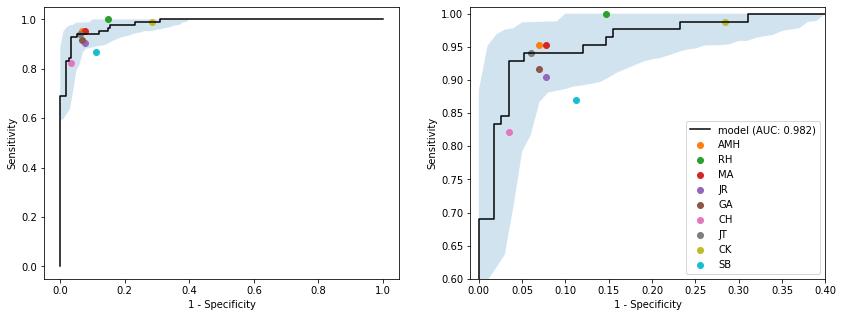

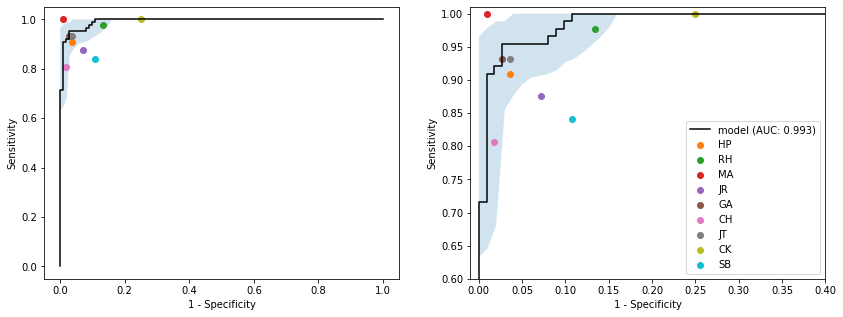

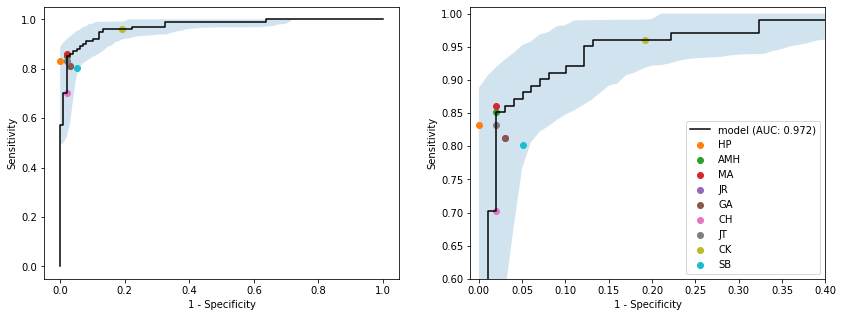

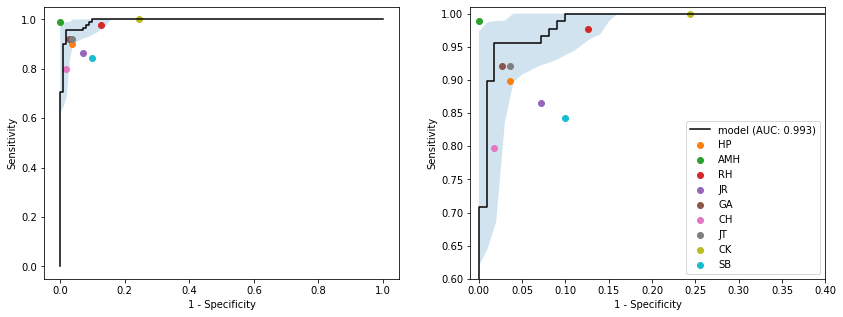

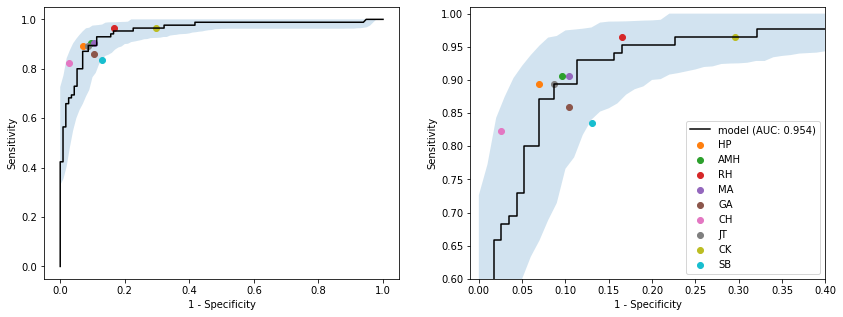

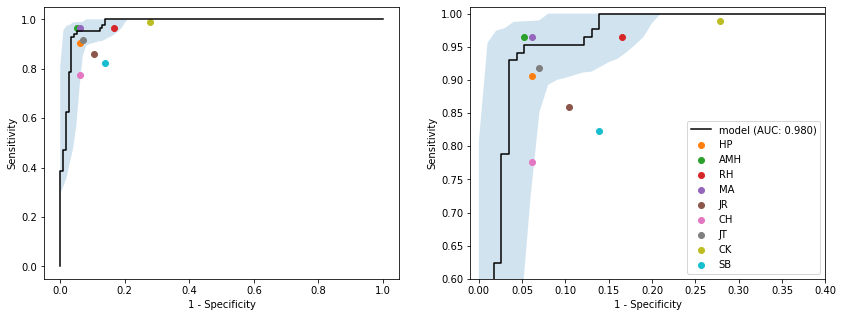

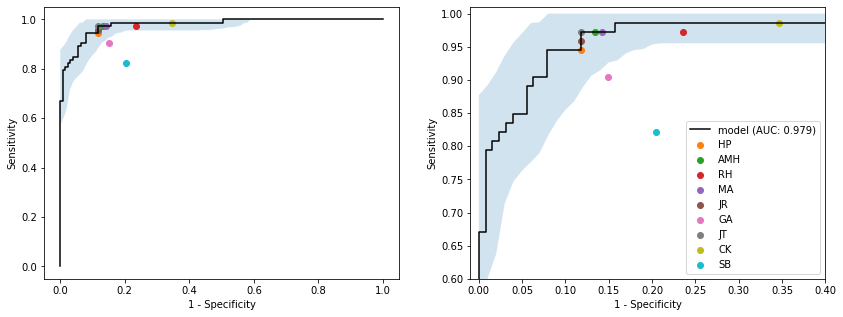

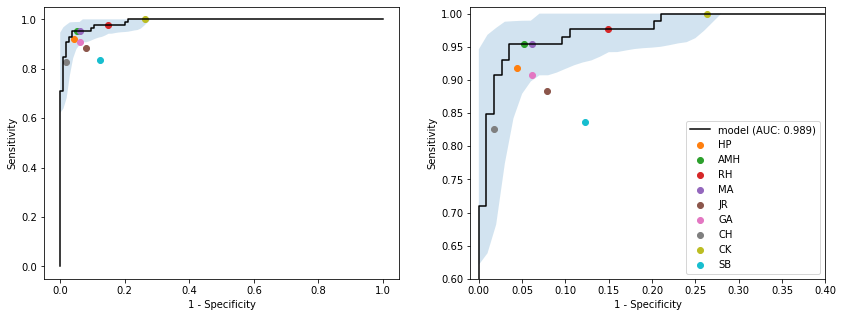

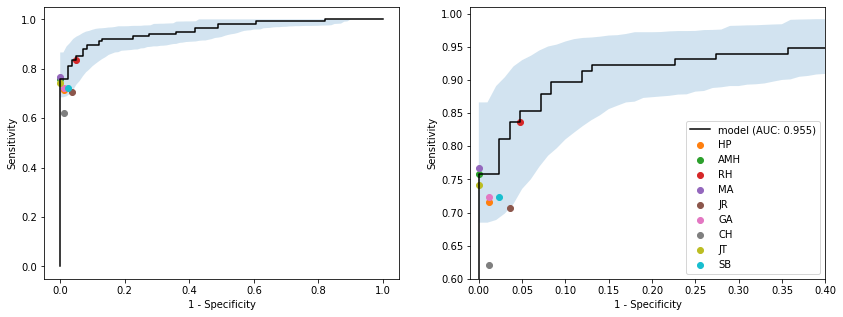

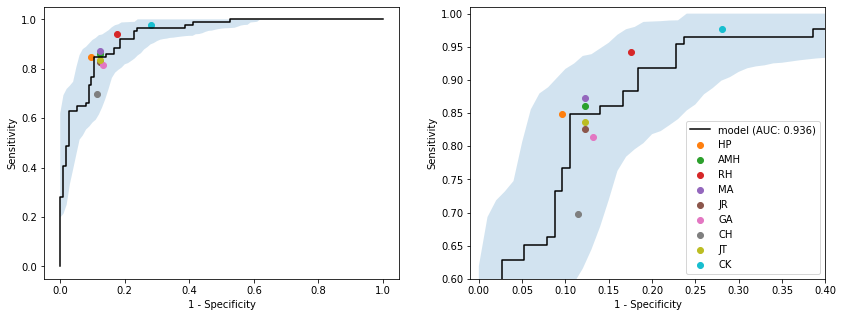

In [21]:
from IPython.display import HTML
for reference in all_graders:
    display(HTML('<h3>{}</h3>'.format(reference)))
    auc, fpr, tpr, lower_fpr, upper_fpr, observer_points = get_bootstrap_scores(reference=reference)
    plot_ROC(auc, fpr, tpr, lower_fpr, upper_fpr, observer_points)

In [22]:
def plot_bootstrap_roc(reference, class_name='normal', invert=False):
    
    if invert:
        ensemble_sample = [1 - model_gradings[fn, class_name] for fn in test_filenames]
        reference_sample = [all_gradings[reference, fn]!=class_name for fn in test_filenames]
    else:
        ensemble_sample = [model_gradings[fn, class_name] for fn in test_filenames]
        reference_sample = [all_gradings[reference, fn]==class_name for fn in test_filenames]
        
    fpr, tpr, threshold = metrics.roc_curve(reference_sample, ensemble_sample)

    lower_fpr, upper_fpr, bootstrap_samples = bootstrap_model(reference, class_name, invert)

    plt.figure(figsize=(30, 10))

    for i, observer in enumerate(all_graders):
        ax = plt.subplot(2, 5, i+1)

        ax.plot(fpr, tpr, label='ensemble', c='k')
        ax.fill_between(base_fpr, lower_fpr, upper_fpr, alpha=0.2)

        se, sp, xerr, yerr = get_error_bar(reference, observer, bootstrap_samples)
        ax.errorbar(1 - sp, se, yerr=yerr, xerr=xerr, capsize=10, c='r') 

        ax.set_title(observer)
        ax.set_xlabel('1 - Specificity')
        ax.set_ylabel('Sensitivity')
        ax.set_ylim(0.5, 1.01)
        ax.set_xlim(0.0, 0.9)
    plt.show()

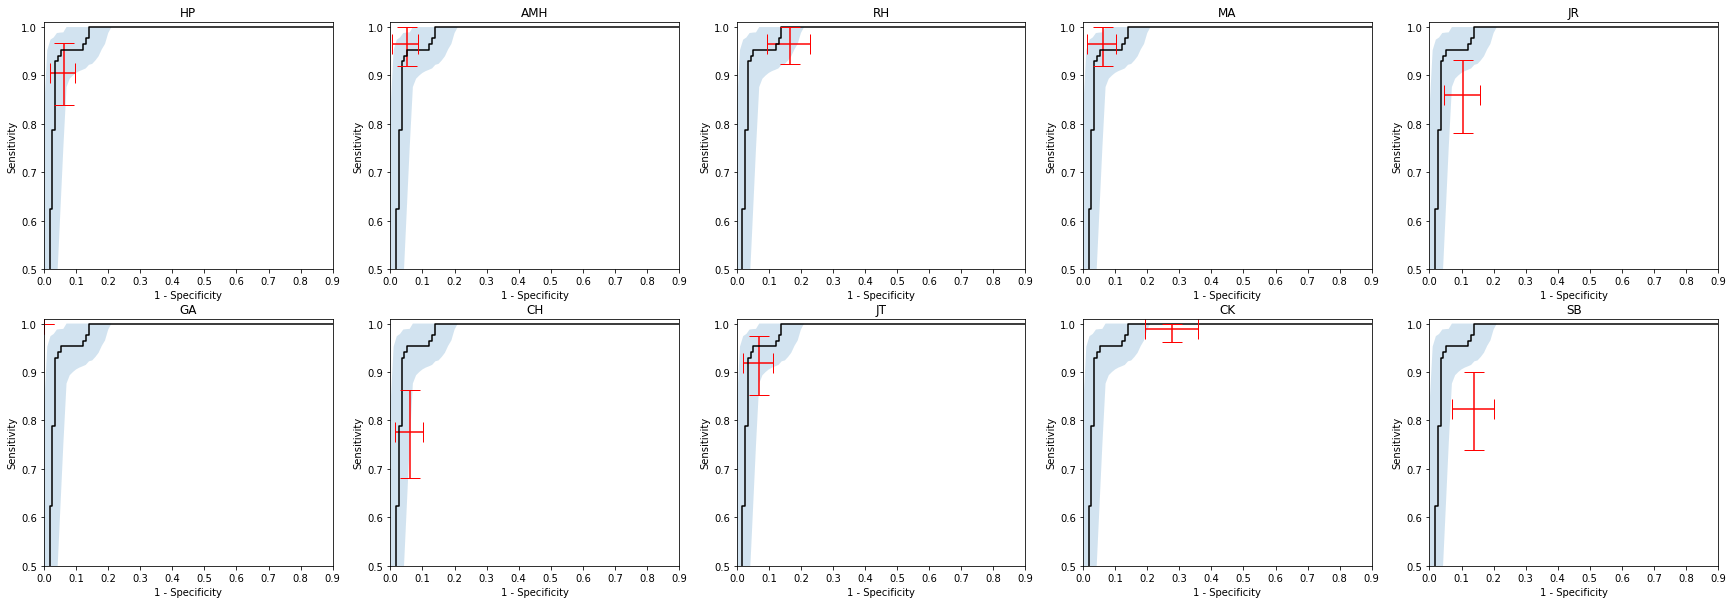

In [23]:
# Compare model and graders to GA
plot_bootstrap_roc('GA', class_name='normal', invert=True)

## AUC compared to different reference graders

In [24]:
for class_name in class_names:
    print(class_name)
    print('reference  AUC')
    o = [model_gradings[fn, class_name] for fn in test_filenames]
    for grader in graders_full_set:
        r = [all_gradings[grader, fn] == class_name for fn in test_filenames]    
        print('{:10s} {:.3f}'.format(grader, roc_auc_score(r, o)))
    print()

    r = [all_gradings['majority', fn] == class_name for fn in test_filenames]
    print('{:10s} {:.3f}'.format('majority', roc_auc_score(r, o)))
    print()
    print()
    

normal
reference  AUC
JR         0.954
HP         0.982
CH         0.979
MA         0.993
JT         0.989
AMH        0.993
CK         0.955
SB         0.936
GA         0.980
RH         0.972

majority   0.988


pre-plus
reference  AUC
JR         0.822
HP         0.883
CH         0.791
MA         0.893
JT         0.893
AMH        0.882
CK         0.701
SB         0.790
GA         0.914
RH         0.880

majority   0.933


plus
reference  AUC
JR         0.947
HP         0.957
CH         0.935
MA         0.935
JT         0.960
AMH        0.920
CK         0.952
SB         0.901
GA         0.958
RH         0.968

majority   0.973




## AUC for each class

In [25]:
def print_auc(reference):

    for class_name in class_names:
        r = [all_gradings[reference, fn] == class_name for fn in test_filenames]
        o = [model_gradings[fn, class_name] for fn in test_filenames]

        print('{:8s} {:.3f}'.format(class_name, roc_auc_score(r, o)))

In [26]:
print_auc('HP')

normal   0.982
pre-plus 0.883
plus     0.957


In [27]:
print_auc('GA')

normal   0.980
pre-plus 0.914
plus     0.958


## Check ambiguous files

In [28]:
# unequivocal = all graders agree on same label
unequivocal_filenames = [fn for fn in test_filenames if len({all_gradings[grader, fn] for grader in graders_full_set}) == 1]
# ambiguous = at least two different labels (including all graders)
ambiguous_filenames = [fn for fn in test_filenames if len({all_gradings[grader, fn] for grader in graders_full_set}) > 1]
# model errors = model disagrees with majority
model_errors = [fn for fn in test_filenames if all_gradings['majority', fn] != all_gradings['ensemble', fn] ]
len(unequivocal_filenames), len(ambiguous_filenames), len(model_errors)

(87, 113, 26)

In [29]:
for fn in ambiguous_filenames:
    print(fn)   
   
    for class_name in class_names:
        print('{:10s} '.format(class_name), [grader for grader in all_graders if all_gradings[grader, fn] == class_name])
    
    print('ensemble: {:102}'.format(all_gradings['ensemble', fn]))
    print('ensemble: {:.2f} {:.2f} {:.2f}'.format(*[model_gradings[fn, class_name] for class_name in class_names]))
    print()

fad42744-74e4-40c2-9679-7eaa158c5de1.1.png
normal      []
pre-plus    ['JR', 'CH']
plus        ['HP', 'AMH', 'RH', 'MA', 'GA', 'JT', 'CK', 'SB']
ensemble: plus                                                                                                  
ensemble: 0.00 0.02 0.98

11b3d2ca-b2be-4c52-80a9-9f645ed03c2e.22.png
normal      ['JR', 'CH']
pre-plus    ['HP', 'AMH', 'RH', 'MA', 'GA', 'JT', 'SB']
plus        ['CK']
ensemble: pre-plus                                                                                              
ensemble: 0.06 0.94 0.00

9f421e90-c634-4fc6-8eca-909a825f5908.10.png
normal      []
pre-plus    ['HP', 'AMH', 'MA', 'JR', 'CH', 'SB']
plus        ['RH', 'GA', 'JT', 'CK']
ensemble: plus                                                                                                  
ensemble: 0.00 0.19 0.81

91f8a621-37ee-4518-803b-16df1a6d4f04.16.png
normal      ['CH', 'JT']
pre-plus    ['HP', 'AMH', 'RH', 'MA', 'JR', 'GA', 'CK', 'SB']
plus        []
en

In [30]:
def plot_matrix(filenames):
    matrix = np.array([
        [
            1 - model_gradings[fn, 'normal'],
            class_names.index(all_gradings['ensemble', fn]) / 2,
            class_names.index(all_gradings['majority', fn]) / 2,
            *[class_names.index(all_gradings[grader, fn]) / 2
              for grader in all_graders
             ]
        ]
        for fn in filenames
    ])

    plt.figure(figsize=(18, 12))
    plt.imshow(matrix[matrix[:, 0].argsort()], aspect = (len(all_graders) + 1) / len(filenames),
              interpolation='none')
    labels = ('not normal', 'ensemble', 'majority', *all_graders)
    plt.gca().set_xticks(range(len(labels)))
    plt.gca().set_xticklabels(labels)

## Model disagrees with majority

Interpretation of plots:  
- Vertical axes is different files, horizontal access different graders. Color is assigned label  
- 'not normal' = 1 - probability assigned to normal class (ensemble model)  
- 'ensemble' = class with highest probability of ensemble model

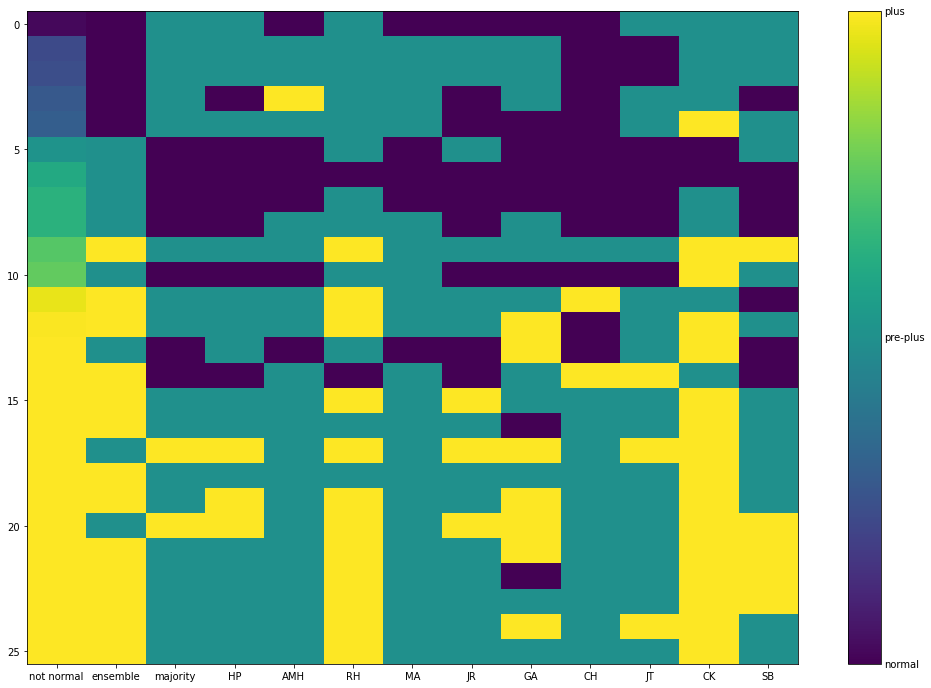

In [31]:
plot_matrix(model_errors)

cbar = plt.colorbar(ticks=[])
for j, (c, label) in enumerate(zip(['w', 'w', 'k'], class_names)):
    cbar.ax.text(1.1, j/2, label, ha='left', va='center', c='k')


Above: showing model errors (26 cases where model disagrees with majority). Mostly because majority is pre-plus and model plus. Note that RH and CK also assign plus in most of these cases.

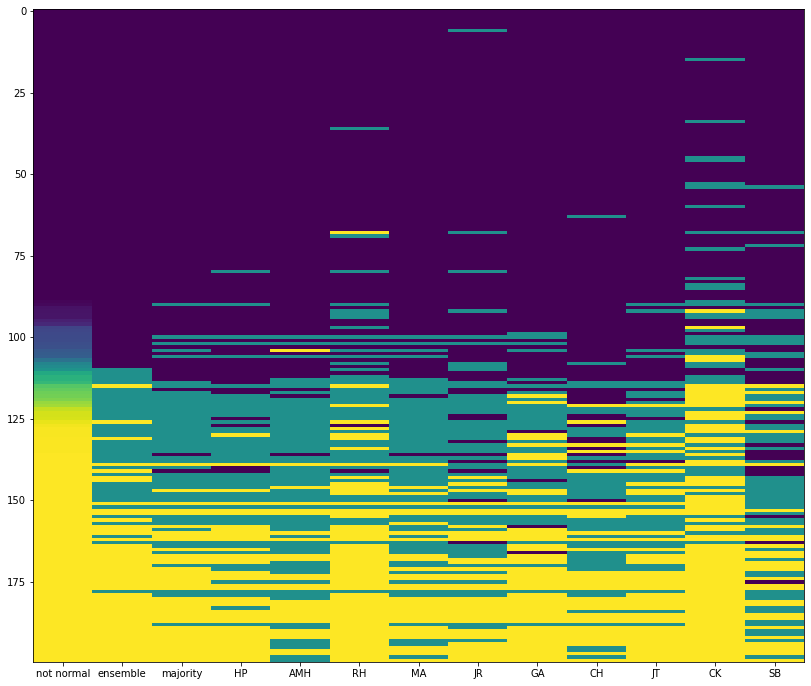

In [32]:
plot_matrix(test_filenames)

Above: all labels of all graders and model visualized, sorted by 'not normal' score (=referability)

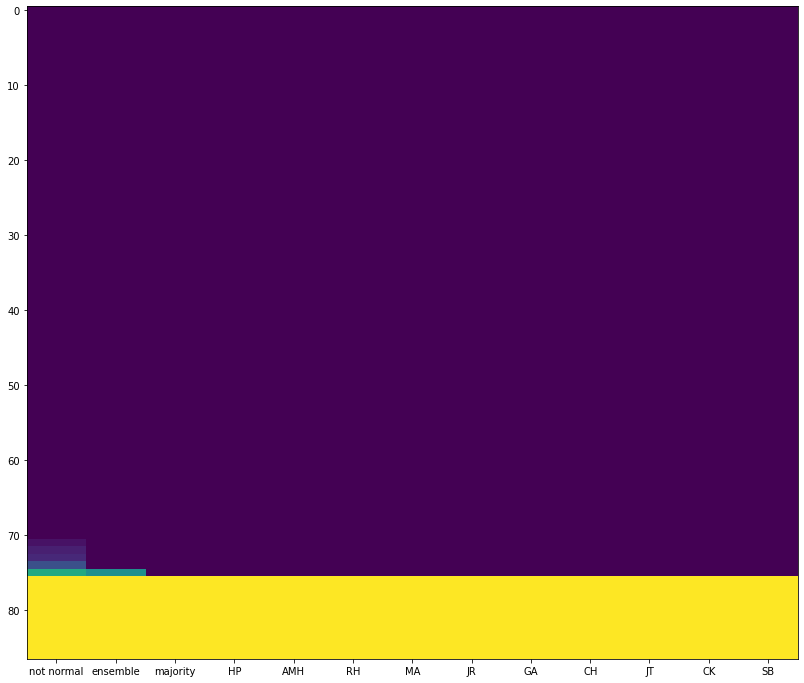

In [33]:
plot_matrix(unequivocal_filenames)

Above: of all files with unanimous label the model agrees except for 1 file classified as pre-plus instead of normal

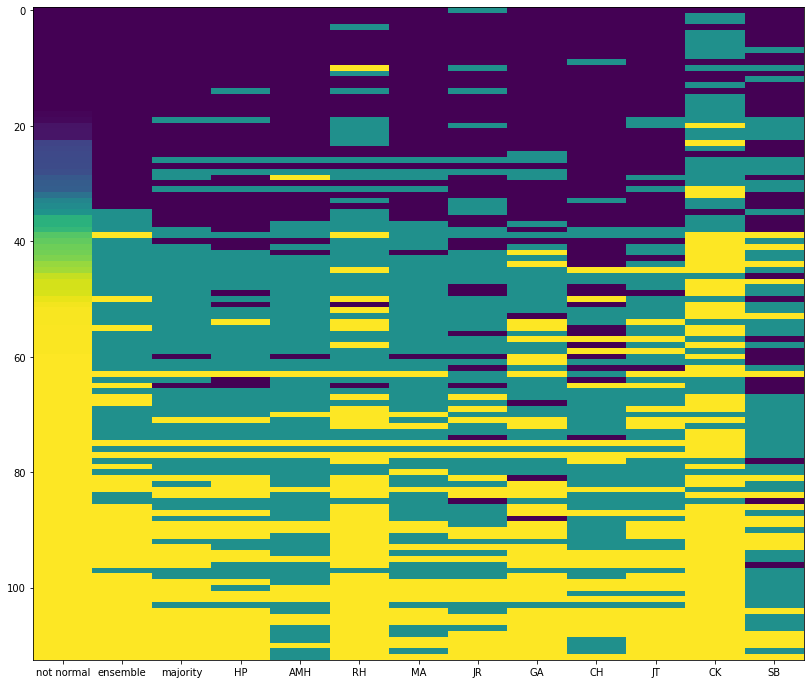

In [34]:
plot_matrix(ambiguous_filenames)

Above: files where graders disagree (mainly pre-plus/plus)

## Confusion matrix

In [35]:
def valid(obs, fn):
    return all_gradings[obs, fn] in class_names

def get_matrix(keys, class_name, filenames):
    
    n = len(keys)
    matrix = np.zeros((n, n))

    for y, obs_y in enumerate(keys):
        for x, obs_x in enumerate(keys):
            include_filenames = [fn for fn in filenames if valid(obs_y, fn) and valid(obs_x, fn)]
            y_bin = np.array([all_gradings[obs_y, fn] == class_name for fn in include_filenames])
            x_bin = np.array([all_gradings[obs_x, fn] == class_name for fn in include_filenames])

            agreement = np.sum(y_bin==x_bin) / len(include_filenames)
            matrix[y, x] = agreement
            #print('{:0.2f}'.format(agreement), end = ' ')
        #print()
    return matrix
        
def plot_confusion(keys, matrix):
    n, n = matrix.shape
    fig = plt.figure(figsize=(15, 15))
    plt.clf()
    ax = fig.add_subplot(111)
    r = ax.imshow(matrix, clim=[0,1])
    for x in range(n):
        for y in range(n):
            ax.annotate('{:0.2f}'.format(matrix[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    ax.set_xticks(range(0, n))
    ax.xaxis.tick_top()
    ax.set_yticks(range(n-1, -1, -1))
    ax.set_xticklabels(keys)
    ax.set_yticklabels(keys[::-1])
    ax.set_xlim(-0.5, n-0.5)
    ax.set_ylim(n-0.5, -0.5)
    cb = fig.colorbar(r)


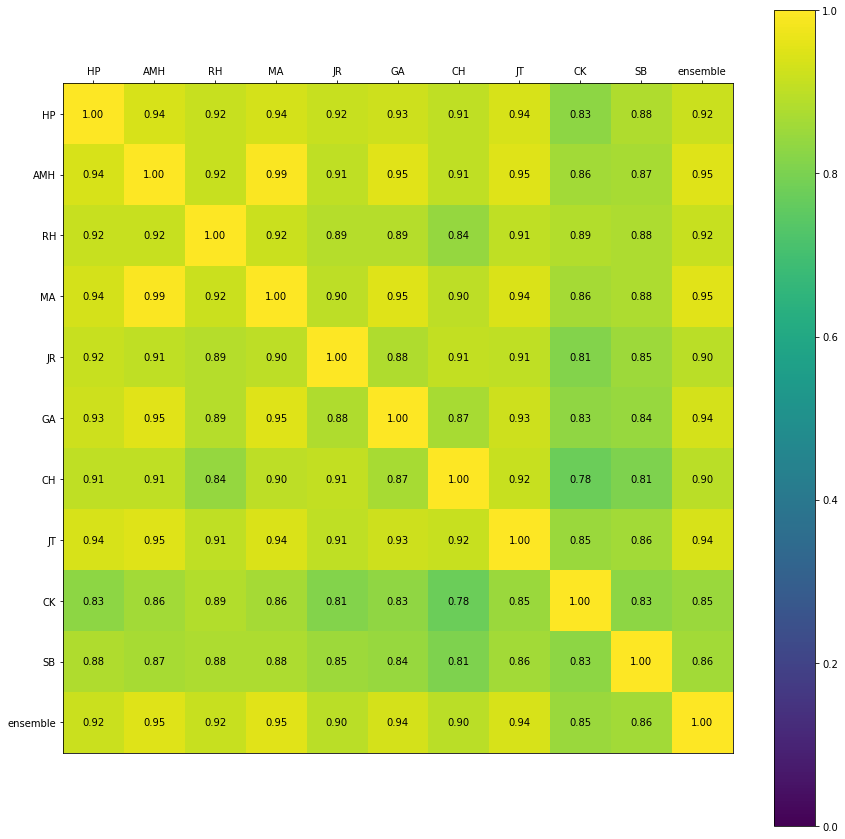

In [36]:
keys = all_graders + ('ensemble',)
plot_confusion(keys, get_matrix(keys, 'normal', test_filenames))

Above: agreement on label 'normal' for all pairs

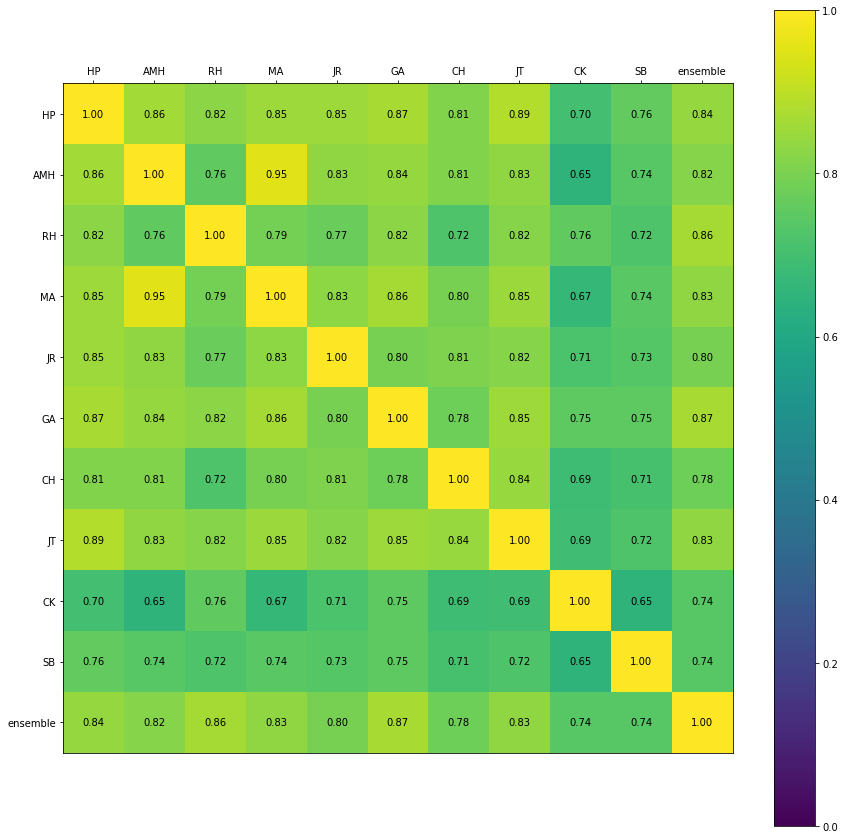

In [37]:
plot_confusion(keys, get_matrix(keys, 'pre-plus', test_filenames))

Above: pair-wise agreement on label pre-plus

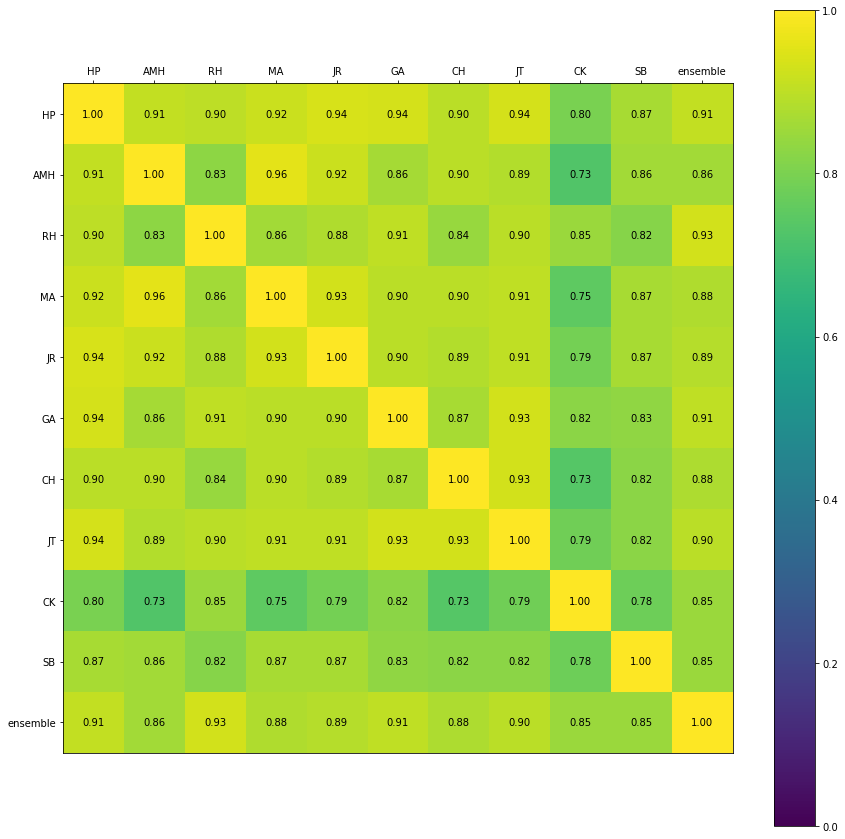

In [38]:
plot_confusion(keys, get_matrix(keys, 'plus', test_filenames))

Above: pair-wise agreement on label plus

## Results external set

In [39]:
with open('results_external.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    results_external = [(label, file, float(n), float(pp), float(p))
                        for label, file, n, pp, p in reader]

In [40]:
y_ref = np.array([r[0] for r in results_external])
y_pred = np.array([class_names[np.argmax(r[2:])] for r in results_external])

In [41]:
acc = np.count_nonzero(y_ref == y_pred) / len(y_ref)
acc

0.83

accuracy = 83%

In [42]:
sensitivity, specificity, tp, tn, fp, fn = se_sp(y_ref!='normal', y_pred!='normal')
sensitivity, specificity, tp, tn, fp, fn

(0.9782608695652174, 1.0, 45, 54, 0, 1)

sensitivity / specificity for referability = 0.98 / 1.0

0.999597423510467


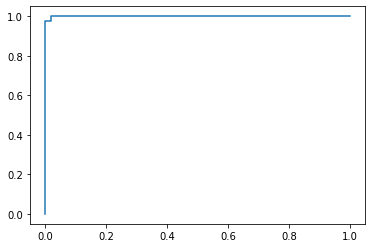

In [49]:
x = y_ref!='normal'
y = [1 - r[header.index('normal')] for r in results_external]

fpr, tpr, threshold = metrics.roc_curve(x, y)
plt.plot(fpr, tpr)
print(roc_auc_score(x, y))

AUC for referability is 0.999

In [50]:
print('{:10s} '.format('Label'), 'model classification')
for class_name in class_names:
    print('{:10s} '.format(class_name), Counter(y_pred[y_ref == class_name]))

Label       model classification
normal      Counter({'normal': 54})
pre-plus    Counter({'plus': 16, 'pre-plus': 14, 'normal': 1})
plus        Counter({'plus': 15})


Above: Model classifies all normal and all plus cases correctly, pre-plus is more problematic

0.935483870967742

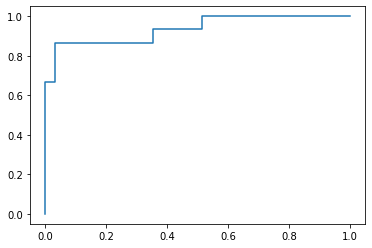

In [52]:
# check pre-plus plus on referable cases:

referables = y_ref != 'normal'

x = (y_ref == 'plus')[referables]
y = np.array([r[header.index('plus')] for r in results_external])[referables]

fpr, tpr, threshold = metrics.roc_curve(x, y)
plt.plot(fpr, tpr)

roc_auc_score(x, y)

AUC for plus/pre-plus on referable cases is 0.9354 (so with better calibration the performance on pre-plus class could be improved)